# 4-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요! (4. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기)
##### !. 작성자의 OS가 mac인 관계로 주요 라이브러리(xgboost, lightgbm)들 실행에 어려움이 있어 colab pro에서 작성되었습니다.

### 참여 Kaggle 대회
2019 2nd ML month with KaKR link: https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr  
DATA는 Aiffel에서 제공받아 진행했습니다.

---

## STEP0. 분석을 위한 데이터 전처리 및 데이터 이해.


In [ ]:
# 필요한 라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join # 파일 경로를 사용하기 위한 라이브러리

import pandas as pd
import numpy as np

import missingno as msno # 결측 데이터 확인용 라이브러리

import xgboost as xgb # 희귀모델을 구현하기 위한 라이브러리
import lightgbm as lgb # 희귀모델을 구현하기 위한 라이브러리

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#데이터 준비하기
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')  # 테스트, 즉 submission 시 사용할 데이터 경로
print(train_data_path) #경로 확인용
print(test_data_path) #경로 확인용

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


/root/LMS/[E-04]Kaggle/data/train.csv
/root/LMS/[E-04]Kaggle/data/test.csv


In [ ]:
# 데이터 확인
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
# date를 먼저 전처리해줌
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()
# int, 정수형 데이터로 처리
# 모델이 date도 예측을 위한 특성으로 활용 가능


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
# 두번째로 타겟 데이터에 해당하는 price컬럼을 처리
# y 변수에 pirce를 넣어두고, train에서는 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
# 세번째로 id 컬럼을 삭제로 전처리 마뤼
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
# 테스트 데이터에도 같은 작업을 수행
# 단 test 데이터에는 price 값이 없으므로 처리필요 X
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
# 타겟 데이터 y확인
y # 큰 값들로 이루어져 있음을 확인

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

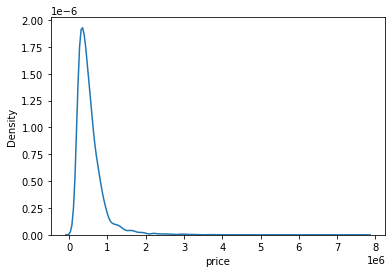

In [ ]:
#seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인.
sns.kdeplot(y)
plt.show() # 왼쪽으로 크게 치우쳐 있는 형태

In [ ]:
# 위 그래프를 기준으로 y는 np.loglp() 함수를 통해 로그 변환.
# 추후 모델이 값을 예측 한후에 다시 np.expml()을 활용해서 되돌리기.
# np.expml()은 np.loglp()과는 반대로는 각 원소 x마다 exp(x)-1의 값을 반환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

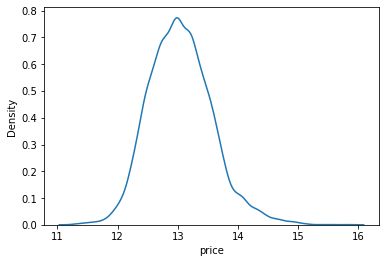

In [ ]:
sns.kdeplot(y)
plt.show() # 코드 실행시 완만한 정규분포의 형태로 변환된 것을 확인할 수 있음

In [ ]:
# info() 함수로 전체 데이터의 자료형을 한눈에 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [ ]:
# RMSE 계산
# 필요 라이브러리 불러오기 
# 데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 train_test_split
from sklearn.model_selection import train_test_split
# RMSE 점수를 계산하기 위한 mean_squared_error를 가져옴.
from sklearn.metrics import mean_squared_error


In [ ]:
# 대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위한 함수를 만들어야함.
# y_tset나 y_pred는 위에서 np.loglp()로 변환된 값이기 때문에 원래 데이터 단위 맞게 되돌리기 위해 np.expml()울 추가해야함.
# exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있음.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [ ]:
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델을 구현
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [ ]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값. 
#random_state=None    # 이게 초기값. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택.  
random_state=2020        # 여기서는 2020 고정값을 세팅 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [ ]:
# 각 모델의 이름은 클래스의 __name__ 속성에 접근해서 얻을 수 있음
gboost.__class__.__name__ # 'GradientBoostingRegressor'

'GradientBoostingRegressor'

In [ ]:
# 이름에 접근이 가능하면 for문 안에서 각 모델 별로 학습 및 예측이 가능해짐
df = {} 

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

#위 코드를 사용하면 네가지 모델에 대한 RMSE 값을 빠르게 구할 수 있음
# 'GradientBoostingRegressor': 128360.19649691365,
# 'LGBMRegressor': 111920.36735892233,
# 'RandomForestRegressor': 125487.07102453562,
# 'XGBRegressor': 131067.44622809246}

[15:16:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562,
 'XGBRegressor': 131067.44622809246}

In [ ]:
# 위의 과정을 get_Scores(models, train, y) 함수로 만드는 코드
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

[15:18:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,131067.446228
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359


In [ ]:
# RMSE 결괏값을 나타내주는 함수준비 후, 다양한 하이퍼 파라미터로 실험.
# sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용
from sklearn.model_selection import GridSearchCV
# GridSearchCV는 다양한 파라미터를 입력하면 가능한 모든 조합을 탐색하는 라이브러리
# param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
# scoring : 모델의 성능을 평가할 지표
# cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
# verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
# n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수



In [ ]:
# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [ ]:
# 다음 모델은 LightGBM(lgbm)를 사용해서 준비
model = LGBMRegressor(random_state=random_state)


In [ ]:
# GridSearchCV를 이용해서 grid_model을 초기화
# train과 y 데이터로 모델을 간단히 학습
# param_grid 내의 모든 하이퍼 파라미터의 대해 실험이 완료
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)
#? totalling 20 fits 로 계산된 이유.
## 입력한 param_grid에 n_estimators 두 가지, max_depth 두 가지를 넣었으므로 가능한 조합은 총 2 × 2 = 4가지
## 또한, cross validation은 각 경우마다 5번을 진행하니 총 20 fits를 진행
## 여기에서 cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다
## 즉, 한 번만 해보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확한 이치

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# grid_model.fit 함수를 통해서 4가지 조합에 대한 실험을 마친 뒤 결과를 grid_model.cv_results_ 안에 저장
grid_model.cv_results_

# 정보가 너무 많이 나오기 때문에 필요한 정보만 빼내는 것이 필요

{'mean_fit_time': array([0.30564194, 0.43081322, 1.13676786, 1.76535702]),
 'mean_score_time': array([0.03340158, 0.0453887 , 0.06104732, 0.08090219]),
 'mean_test_score': array([-0.07339447, -0.05502043, -0.02917734, -0.02702714]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

In [ ]:
# 파라미터 조합은 위 딕셔너리 중 params에, 각각에 대한 테스트 점수는 mean_test_score에 저장되어 있음
# 두 정보만 빼내는 코드
# paprams
params = grid_model.cv_results_['params']
params


[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [ ]:
# mean_test_test_score
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [ ]:
# params 에는 각 파라미터의 조합이, score에는 각 조합에 대한 점수가 들어가 있음
# 이제 이 둘만 가지고 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아냄
# 데이터 프레임을 출력하는 코드
results = pd.DataFrame(params)
results['score'] = score

results  # neg_mean_squared_error를 사용했기 때문에 점수가 음수로 표현.

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [ ]:
# 간단한 변환 함수로 RMSE 점수를 볼 수 있도록 함
# 음수로 된 MSE였기 때문에, -1을 곱하고 np.sqrt로 루트 연산을 실행
results['RMSE'] = np.sqrt(-1 * results['score'])
results
# get socore에서 보였던 10만 단위의 결과보다는 크기가 아주 달라보임
# 그 이유는 price에 있음.
# price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log를 변환
# 그 후 RMSE 값을 계산하기 위한 함수에서는 np.expml 함수를 활용해 다시 원래대로 복원한후 RMSE 값을 계싼
# 그러나 그리드 탐색을 할때는 앞서 설명한 expml()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수 갑ㅅ을 계싼
# 아래 마이너스 값은 RMSE값이 아닌 RMSLE(Root Mean Squared Log Error)로 log를 취한 갑셍서 RMSE를 구했다는 것을 알 수 있음

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [ ]:
# 위 결과의 맞춰 컬럼의 이름을 RMSLE로 변환.
# 판단스에서 컬럼의 이름변환은 rename으로 가능
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [ ]:
# RMSLE가 낮은 순서대로 정렬
# sort_values 사용
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [94]:
# 위과정을 하나의 함수로 만드는 코드
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현.

1. GridSearchCV 모델로 `model`을 초기화.
2. 모델을 fitting.
3. params, score에 각 조합에 대한 결과를 저장.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환.
"""
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
# 제출 과정을 깔끔하게 하는 방법
# my_GridSearch()함수로 간단한 그리드 탐색을 진행
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
# 가장 좋은 조합은 max_depth=10, n_estimators=100
# 해당 모델로 학습을 해서 예측값인 submission.csv파일을 만들어서 제출시도.

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [ ]:
# 먼저 해당 파라미터로 구성된 모델을 준비, 학습 후 예측 결과를 생성.
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [ ]:
# 예측 결과에 np.expml()을 씌워서 다시 원래 스케일로 되돌리기
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [ ]:
# sample_submission.csv 파일을 가져오기
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
# 위의 데이터 프레임의 모델이 예측한 값을 덮어씌우면 제출할 데이터가 완성
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [ ]:
# 위의 데이터를 csv 파일로 저장
# 수많은 실험을 대비해 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어 제출 파일들을 깔끔하게 관리
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)


/root/LMS/[E-04]Kaggle/data/submission_lgbm_RMSLE_0.164399.csv


In [155]:
# 위 과정을 하나의 함수로 정리하는 코드
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현.
1. 모델을 `train`, `y`로 학습.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
# 이 함수를 적용 후 다음 한줄로 모델을 학습시킨 후 예측 결과를 저장할 수 있음
save_submission(model, train, y, test, 'lgbm', rmsle='0.168')

# Private Score 115807.04439
# 목표 점수인 11만점이하에 근접해가고 있기에 좀 더 다른 방법들을 시도.

/root/LMS/[E-04]Kaggle/data/submission_lgbm_RMSLE_0.168.csv saved!


---

## STEP1. 프로젝트 본문 시작


## 튜닝해볼 수 있는 모델 클래스 인자들을 이용해 변경해보기.
대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같다.

max_depth : 의사 결정 나무의 깊이, 정수 사용  
learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용  
n_estimators : 사용하는 개별 모델의 개수, 보통 50 ~ 100 이상의 정수 사용  
num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수  
boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력  


## ✓ 시도해볼 수 있는 방법
기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)  
LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기  
다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기  
Baseline 커널에서 활용했던 블렌딩 방법 활용하기  


### 하이퍼 파라미터 튜닝
GridSearchCV의 인자들

param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)  
scoring : 모델의 성능을 평가할 지표  
cv : cross validation을 수행하기 위해   train 데이터셋을 나누는 조각의 개수  
verbose : 그리드 탐색을 진행하면서 진행   과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력)  
n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수  

In [92]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500, 550, 600, 650, 700],
    'max_depth': [1, 10, 15, 20, 25, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 66 candidates, totalling 330 fits


,max_depth,n_estimators,score,RMSLE
37,20,300,-0.026091,0.161527
59,30,300,-0.026091,0.161527
48,25,300,-0.026091,0.161527
16,10,400,-0.026121,0.161619
15,10,300,-0.026127,0.161640
...,...,...,...,...
4,1,300,-0.042028,0.205008
3,1,200,-0.045195,0.212591
2,1,150,-0.048428,0.220064
1,1,100,-0.055020,0.234564


In [97]:
model = LGBMRegressor(max_depth=20, n_estimators=300, random_state=random_state)

save_submission(model, train, y, test, 'lgbm_2', rmsle='0.161527')
# 그리드 탐색범위를 조정해 성능이 가장 좋아보이는 20, 300으로 하이퍼 파라미터를 수정.
# Score: 111329.52684
# Score가 낮아지기는 했으나 아직 부족함.

/root/LMS/[E-04]Kaggle/data/submission_lgbm_2_RMSLE_0.0161527.csv saved!


### 모델 클래스 인자 추가해보기


In [ ]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01], # 학습률 조정
    'n_estimators': [50, 100, 150, 200, 300, 400, 500, 550, 600, 650, 700],
    'max_depth': [1, 10, 15, 20, 25, 30],
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #15m runtime

Fitting 5 folds for each of 198 candidates, totalling 990 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
85,0.05,10,600,-0.025873,0.160852
86,0.05,10,650,-0.025880,0.160873
87,0.05,10,700,-0.025881,0.160877
84,0.05,10,550,-0.025912,0.160971
97,0.05,15,650,-0.025924,0.161010
...,...,...,...,...,...
165,0.01,20,50,-0.138643,0.372348
143,0.01,10,50,-0.138643,0.372348
187,0.01,30,50,-0.138643,0.372348
133,0.01,1,100,-0.166044,0.407484


In [120]:
model = LGBMRegressor(
    learning_rate=0.05, 
    max_depth=10, 
    n_estimators=600, 
    random_state=random_state
)

save_submission(model, train, y, test, 'lgbm_3', rmsle='0.160852')
# 그리드 탐색범위 변경에 더해 학습률과 모델 클래스 인자를 추가 하고 성능이 가장 좋아보이는 0.05 10, 600으로 하이퍼 파라미터를 수정.
# Score: 112290.99295
# Score가 그리드 탐색범위만 바꾼 것보다 값이 더 증가함.


/root/LMS/[E-04]Kaggle/data/submission_lgbm_3_RMSLE_0.160852.csv saved!


In [121]:
model = LGBMRegressor(
    learning_rate=0.1, 
    max_depth=10, 
    n_estimators=600, 
    random_state=random_state
)

save_submission(model, train, y, test, 'lgbm_4', rmsle='0.160852')
# 점수가 더 증가한 것이 이상하다 판단되어 학습률을 0.1로만 변경하고 다시 저장후 제출
# Score: 109840.77026
# 기준 점수 11만점 이하를 달성했으나 다른 추가적인 실습을 위해 추가로 코드작성.

/root/LMS/[E-04]Kaggle/data/submission_lgbm_4_RMSLE_0.160852.csv saved!


In [ ]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [ ]:
param_grid = {
    'num_leaves' : [10, 20, 30], # LGBM 모델의 복잡도를 제어하는 주요 파라미터, num leaves 갯수를 높이면 정확도가 높아지지만, 트리 깊이가 깊어지고 모델 복잡도가 커져 과적합 영향도가 커짐
    'learning_rate': [0.1, 0.05, 0.01], # 학습률 조정
    'n_estimators': [50, 100, 150, 200, 300, 400, 500, 550, 600],
    'max_depth': [1, 10, 15, 20]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #20m runtime

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


,learning_rate,max_depth,n_estimators,num_learves,score,RMSLE
161,0.05,10,600,30,-0.025873,0.160852
159,0.05,10,600,10,-0.025873,0.160852
160,0.05,10,600,20,-0.025873,0.160852
158,0.05,10,550,30,-0.025912,0.160971
157,0.05,10,550,20,-0.025912,0.160971
...,...,...,...,...,...,...
220,0.01,1,100,20,-0.166044,0.407484
221,0.01,1,100,30,-0.166044,0.407484
218,0.01,1,50,30,-0.209696,0.457926
216,0.01,1,50,10,-0.209696,0.457926


In [122]:
model = LGBMRegressor(
    num_learves=30,
    learning_rate=0.05, 
    max_depth=10, 
    n_estimators=600, 
    random_state=random_state
)

save_submission(model, train, y, test, 'lgbm_5', rmsle='0.160852')
# 학습률을 0.05로 다시 변경하고 시도했으나 결과값은 11만점 이상
# Score: 112290.99295
# num_learves=30을 넣기전과 점수 차이가 없음.

/root/LMS/[E-04]Kaggle/data/submission_lgbm_5_RMSLE_0.160852.csv saved!


In [123]:
model = LGBMRegressor(
    num_leaves=30,
    learning_rate=0.1, 
    max_depth=10, 
    n_estimators=600, 
    random_state=random_state
)

save_submission(model, train, y, test, 'lgbm_6', rmsle='0.160852')
# 점수가 더 증가한 것이 이상하다 판단되어 학습률을 0.1로만 변경하고 다시 저장후 제출
# Score: 109840.77026
# num_leaves는 정확도만을 높이는 것으로 판단, 결국 학습률이 영향을 미치고 있음.

/root/LMS/[E-04]Kaggle/data/submission_lgbm_6_RMSLE_0.160852.csv saved!


In [111]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [116]:
param_grid = {
    'num_leaves' : [10, 20], # LGBM 모델의 복잡도를 제어하는 주요 파라미터, num leaves 갯수를 높이면 정확도가 높아지지만, 트리 깊이가 깊어지고 모델 복잡도가 커져 과적합 영향도가 커짐
    'learning_rate': [0.1, 0.05, 0.001], # 학습률 조정
    'n_estimators': [50, 100, 150, 200, 300, 400, 500, 600],
    'max_depth': [1, 10, 15]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #10m runtime

Fitting 5 folds for each of 144 candidates, totalling 720 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
95,0.050,15,600,20,-0.025931,0.161031
79,0.050,10,600,20,-0.025967,0.161143
93,0.050,15,500,20,-0.026025,0.161323
77,0.050,10,500,20,-0.026065,0.161446
27,0.100,10,400,20,-0.026136,0.161666
...,...,...,...,...,...,...
112,0.001,10,50,10,-0.260197,0.510095
99,0.001,1,100,20,-0.262146,0.512002
98,0.001,1,100,10,-0.262146,0.512002
97,0.001,1,50,20,-0.270001,0.519616


In [117]:
model = LGBMRegressor(
    num_leaves=20,
    learning_rate=0.05, 
    max_depth=15, 
    n_estimators=600, 
    random_state=random_state
)

save_submission(model, train, y, test, 'lgbm_7', rmsle='0.161031')
# 학습률을 결정하기 위해 데이터프레임을 보고 판단하기 위한 7번째 분석
# Score: 113538.83278
# 학습률 0.1이 RMSE 값을 낮추는데는 효과적으로 판단 
# LGB모델에서는 학습률 0.1이 나오도록 튜닝할 필요가 있음.

/root/LMS/[E-04]Kaggle/data/submission_lgbm_7_RMSLE_0.161031.csv saved!


In [124]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [125]:
# num leaves는 정확도만을 높이는 것으로 판단되어 시간효율화를 위해 코드에서 제거.
# 실제로 시간이 단축되는 효과가 있었음.
param_grid = {
    'learning_rate': [0.1], 
    'n_estimators': [500, 1000],
    'max_depth': [10, 15]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #5m runtime

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,10,500,-0.026245,0.162004
2,0.1,15,500,-0.026413,0.162521
1,0.1,10,1000,-0.026739,0.163521
3,0.1,15,1000,-0.026958,0.164190


In [126]:
model = LGBMRegressor(
    learning_rate=0.1, 
    max_depth=10, 
    n_estimators=500, 
    random_state=random_state
)

save_submission(model, train, y, test, 'lgbm_8', rmsle='0.162004')
# 학습률을 데이터프레임을 보고 판단하기 위한 8번째 분석
# Score: 110417.28785
# 학습률을 0.1로 제한하고 분석진행 
# LGB모델에서는 학습률 0.1이 나오도록 하고 사용 개별 모델의 개수를 늘리니 rmsle값이 떨어진 것을 알 수 았음

/root/LMS/[E-04]Kaggle/data/submission_lgbm_8_RMSLE_0.162004.csv saved!


In [127]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [128]:
param_grid = {
    'learning_rate': [0.1], 
    'n_estimators': [1000, 1500],
    'max_depth': [10, 15,20]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #5m runtime

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,10,1000,-0.026739,0.163521
4,0.1,20,1000,-0.026786,0.163663
2,0.1,15,1000,-0.026958,0.164190
5,0.1,20,1500,-0.027062,0.164504
1,0.1,10,1500,-0.027106,0.164638
3,0.1,15,1500,-0.027297,0.165217


In [129]:
model = LGBMRegressor(
    learning_rate=0.1, 
    max_depth=10, 
    n_estimators=1000, 
    random_state=random_state
)

save_submission(model, train, y, test, 'lgbm_9', rmsle='0.163521')
# 학습률을 데이터프레임을 보고 판단하기 위한 9번째 분석
# Score: 109412.15647
# 학습률을 0.1로 제한하고 2차 분석진행 
# LGB모델에서는 학습률 0.1이 나오도록 하고 사용 개별 모델의 개수를 1000~1500으로 늘림. rmsle값이 떨어진 것을 알 수 았음
# score 11만점 이하 달성.

/root/LMS/[E-04]Kaggle/data/submission_lgbm_9_RMSLE_0.163521.csv saved!


In [130]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [131]:
param_grid = {
    'learning_rate': [0.1], 
    'n_estimators': [5000, 10000],
    'max_depth': [10, 15,20]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #10m runtime

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
4,0.1,20,5000,-0.027641,0.166257
5,0.1,20,10000,-0.027686,0.166392
0,0.1,10,5000,-0.027759,0.166611
1,0.1,10,10000,-0.027824,0.166805
2,0.1,15,5000,-0.027888,0.166998
3,0.1,15,10000,-0.027932,0.167129


In [132]:
model = LGBMRegressor(
    learning_rate=0.1, 
    max_depth=20, 
    n_estimators=5000, 
    random_state=random_state
)

save_submission(model, train, y, test, 'lgbm_10', rmsle='0.166257')
# 학습률을 데이터프레임을 보고 판단하기 위한 10번째 분석
# Score: 110986.71729
# 학습률을 0.1로 제한하고 4차 분석진행 
# LGB모델에서는 학습률 0.1이 나오도록 하고 사용 개별 모델의 개수를 5000~10000으로 늘림.
# 개별 모델의 개수를 과감하게 늘리는 것이 어떠한 영향을 미치는지 확인하기 위함.
# 결과적으로 분석시간은 늘었고, rmse값은 오히려 증가함
# 1000~1500을 적절한 값으로 판단.

/root/LMS/[E-04]Kaggle/data/submission_lgbm_10_RMSLE_0.166257.csv saved!


### 모델 변경하기

#### 모델 XGBRegressor

In [133]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [135]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01], # 학습률 조정
    'n_estimators': [1000, 1500],
    'max_depth': [1, 10, 15, 20]
}
# 모델 XGBRegressor로 변경
model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #90m runtime


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[04:08:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,learning_rate,max_depth,n_estimators,score,RMSLE
19,0.01,10,1500,-0.026088,0.161519
18,0.01,10,1000,-0.026379,0.162416
10,0.05,10,1000,-0.026451,0.162637
11,0.05,10,1500,-0.026491,0.162761
2,0.10,10,1000,-0.026970,0.164226
3,0.10,10,1500,-0.026970,0.164226
21,0.01,15,1500,-0.027108,0.164645
20,0.01,15,1000,-0.027192,0.164900
13,0.05,15,1500,-0.027381,0.165473
12,0.05,15,1000,-0.027381,0.165473


In [157]:
# 모델 XGBRegressor
model = XGBRegressor(
    learning_rate =0.01,
    max_depth=10,
    n_estimators=1500,
    random_state=random_state    
)
save_submission(model, train, y, test, 'XGB_1', rmsle='0.161519')

# 모델을 변경후 하이퍼파라미터등의 값은 변경하여 사용
# Score: 114368.09338
# 점수가 더 높아짐 XGBRegressor 모델이 LGB모델보다 RMSE가 높은 것을 생각하면 당연한 결과일수도.


[08:24:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/root/LMS/[E-04]Kaggle/data/submission_XGB_1_RMSLE_0.161519.csv saved!


In [152]:
param_grid = {
    'learning_rate': [0.1], # 학습률 제한
    'n_estimators': [1000, 1500],
    'max_depth': [1, 10]
}
# 모델 XGBRegressor로 변경
model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #m runtime

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[08:16:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,learning_rate,max_depth,n_estimators,score,RMSLE
2,0.1,10,1000,-0.026970,0.164226
3,0.1,10,1500,-0.026970,0.164226
1,0.1,1,1500,-0.034949,0.186946
0,0.1,1,1000,-0.036242,0.190374


In [156]:
# 모델 XGBRegressor
model = XGBRegressor(
    learning_rate =0.1,
    max_depth=10,
    n_estimators=1000,
    random_state=random_state    
)
save_submission(model, train, y, test, 'XGB_2', rmsle='0.161519')

# 모델을 변경후 하이퍼파라미터등의 값을 추가적으 변경하여 사용 XGB2차 분석.
# Score: 112826.06162
# 학습률에 제한을 두니 Score가 더 좋아짐
# 굉장히 오래걸리는 분석시간 때문에 프로젝트 효율상 추가적인 분석을 하기에는 적합하지 않다고 판단.

[08:21:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/root/LMS/[E-04]Kaggle/data/submission_XGB_2_RMSLE_0.161519.csv saved!


## 모델 GradientBoostingRegressor 로 진행


In [138]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [139]:
# 모델 GradientBoostingRegressor 로 변경
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [1000, 1500],
    'max_depth': [1, 5, 10],
}
model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #90m runtime

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
8,0.05,5,1000,-0.026455,0.162649
9,0.05,5,1500,-0.026536,0.162899
14,0.10,5,1000,-0.027061,0.164503
15,0.10,5,1500,-0.027412,0.165565
3,0.01,5,1500,-0.027416,0.165577
2,0.01,5,1000,-0.028473,0.168740
5,0.01,10,1500,-0.029166,0.170780
4,0.01,10,1000,-0.029177,0.170814
10,0.05,10,1000,-0.029344,0.171300
11,0.05,10,1500,-0.029350,0.171319


In [140]:
model = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=5, 
    n_estimators=1000, 
    random_state=random_state)

save_submission(model, train, y, test, 'GBR_1', rmsle='0.162649')

# 모델을 변경후 하이퍼파라미터등의 값을 변경
# Score: 114368.09338
# GBR모델도 점수가 높게나오는 것을 확인.

/root/LMS/[E-04]Kaggle/data/submission_GBR_1_RMSLE_0.162649.csv saved!


## 모델 RandomForestRegressor 로 진행


In [141]:
# 데이터 전처리 재진행
data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']


test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [142]:
# RandomForestRegressor
param_grid = {
    "n_estimators":[50, 100, 500, 600, 650, 2000 ],
    "max_depth":[1, 5, 10, 15, 20, None]
}
model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) #150m runtime

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,max_depth,n_estimators,score,RMSLE
35,NaN,2000,-0.031359,0.177085
29,20.0,2000,-0.031377,0.177135
33,NaN,600,-0.031402,0.177207
34,NaN,650,-0.031410,0.177229
27,20.0,600,-0.031434,0.177295
28,20.0,650,-0.031440,0.177313
32,NaN,500,-0.031461,0.177373
26,20.0,500,-0.031488,0.177448
23,15.0,2000,-0.031694,0.178028
21,15.0,600,-0.031746,0.178173


In [143]:
# 모델 RandomForestRegressor로 변경
model = RandomForestRegressor(
    max_depth=None,
    n_estimators=2000,
    random_state=random_state
)
save_submission(model, train, y, test, 'RandomForest_2', rmsle='0.177085')

# 모델을 변경후 하이퍼파라미터등의 값도 재설정
# 500 = score 133154.54734
# 2000 = scoroe 133142.43715
# 점수가 더 높아짐 RandomForestRegressor 모델로는 원하는 결과를 뽑아내기 어려운 것으로 판단됨.

/root/LMS/[E-04]Kaggle/data/submission_RandomForest_2_RMSLE_0.177085.csv saved!


## 앙상블 기법

In [ ]:
# 앞선 모델변경 중 2개의 모델(LGB, XGB)을 앙상블 하여 결과를 도출해내기로 결정.

In [158]:
# 점수가 가장 좋게 나온 하이퍼파라미터값을 사용
model1 = LGBMRegressor(
    learning_rate=0.1,
     max_depth=10, 
     n_estimators=1000, 
     random_state=random_state)


In [159]:
# 점수가 가장 좋게 나온 하이퍼파라미터값을 사용
model2 = XGBRegressor(
    learning_rate =0.1,
    max_depth=10,
    n_estimators=1000,
    random_state=random_state
)

In [160]:
def fit_prediction(model, train, y, test):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    return prediction
    
def save_submission(prediction, model_name, rmsle=None):
    data_dir = os.getenv('HOME')+'/LMS/[E-04]Kaggle/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [161]:
prediction1 = fit_prediction(model1, train, y, test)
prediction2 = fit_prediction(model2, train, y ,test)

ens = prediction1 * 0.5 + prediction2 * 0.5 # 수치는 아주 큰차이가 없다고 판단 가중치는 비슷하게 부여
save_submission(ens, 'enstesteee')
# 기존 분석에서 좋은결과가 나온 LGBM과 RMSE값이 높은 XGB를 앙상블하여 출력
# score 1108234.03293 출력
# RMSE점수가 가장낮았던 LGBM과 XGB를 앙상블하여 출력한 결과가 만족스럽게 출력됨


[08:26:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/root/LMS/[E-04]Kaggle/data/submission_enstesteee_RMSLE_None.csv saved!


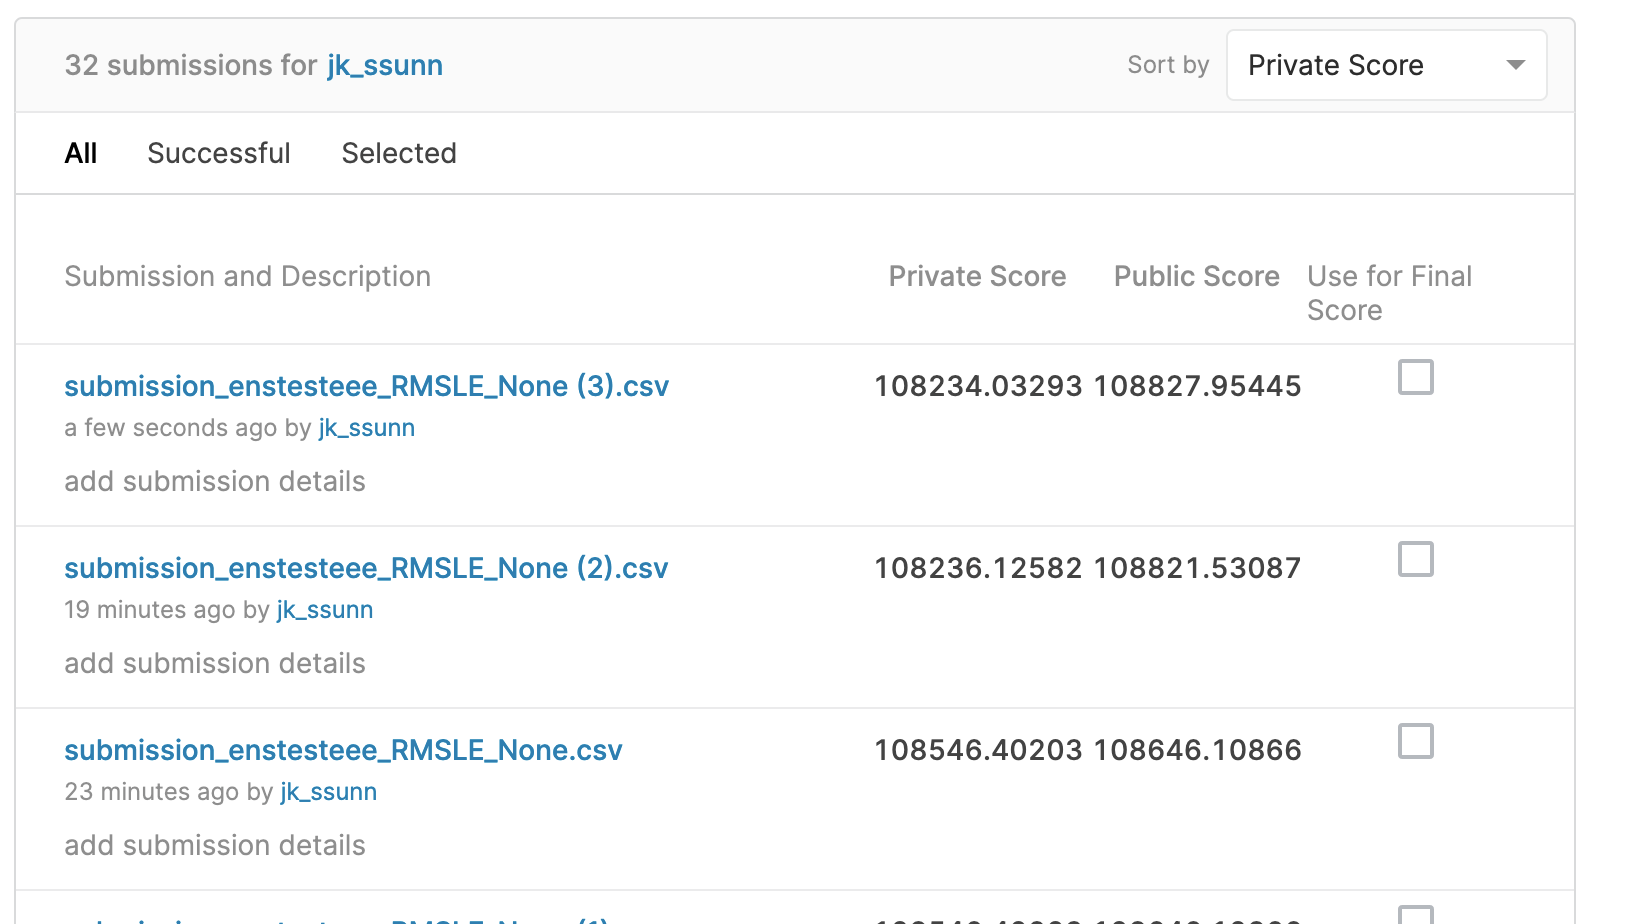

---

### 평가기준.  
데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?  
제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?  
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?  

---

### 회고록.
Kaggle 데이터를 사용해 데이터를 분석할 수 있도록 전처리후, 적절한 하이퍼 파라미터값찾아내기 위해 모델 클래스 인자를 변경해보고, 데이터의 피처 모델을 잘표현하기 위한 LGBMRegressor, XGBRegressor, GradientBosstingRegressor, RandomForestRegressor등의 여러가지 모델들을 응용하여 Score 11만점을 뽑아내기 위해 최적화 해보는 네번째 Explation이었다.  
이 프로젝트를 진행하면서 부딪힌 벽이 꽤나 많았다. Mac os에서 라이브러리를 사용하기 위해서는 추가적이 작업이 필요했는데 이 부분을 간단하게 해결하고자 Colab을 사용했다.    Colab은 익숙하지 않아 초반 어려움을 겪었다. 게다가 모델을 피처링 하는시간이 상당히 길었는데, 작업실행중 서버연결이 끊겨 분석결과가 날라간 상황을 두번이나 겪은 것은 꽤나 치명적이었다.  때문에 데이터 전처리는 그대로 두고 모델의 인자값들의 상관성을 분석해보면서 상관성이 낮지만 시간을 잡아먹는 듯한 인수들은 시간을 단축하기 위해 최대한 배제했다.  다행히도 제시간안에 11만이하의 score를 뽑아낼 수 있었다.  
이는 Exp에서 기본적으로 11만점에 근접하는 하이퍼파라미터값을 미리 선정해준 덕분이기도 할 것이다.

차후 이런 kaggle 분석을 할 때마다 결국 전처리부터 시작해 하이퍼 파라미터를 처음부터 정해야 할텐데 적절한 값을 선정할 수 있을지 걱정이 앞서기도 한다.  
반대로 kaggle에 도전하고 싶은마음도 커졌다.  kaggle 데이터 분석 공부 필요.

---

### Reference.  
Evan 외 5명. (2021). 파이썬으로 캐글 뽀개기 : 파이썬으로 시작해서 포트폴리오로 취업까지. 비제이퍼블릭  
Pandas Lambda, apply를 활용하여 복잡한 로직 적용하기(https://data-newbie.tistory.com/207)  
skaborn.kdeplot (https://seaborn.pydata.org/generated/seaborn.kdeplot.html)  
결정계수 R squared (https://ltlkodae.tistory.com/19)  
numpy.log1p(https://numpy.org/doc/stable/reference/generated/numpy.log1p.html)  
numpy.expm1(https://numpy.org/doc/stable/reference/generated/numpy.expm1.html)  
사이킷런 - The scoring parameter: defining model evaluation rules (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)  
pandas.DataFrame.sort_values (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)
lightGBM / XGBoost 파라미터 설명(http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)  
Chapter 4. 분류 - LightGBM(https://injo.tistory.com/48)  
대회 커널 (https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks)